# Memprediksi jumlah pesanan taksi perusahaan Sweet Lift

Deskripsi tugas

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

## Persiapan

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.spatial import distance
from IPython.display import display
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
import lightgbm as lgb
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# set tema untuk seaborn
sns.set_theme(palette='bright')

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


terlihat bahwa dataset berisikan 2 kolom dengan 26496 entry, tidak ada nilai hilang, akan tetapi kolom `datetime`  memiliki tipe data yang salah sehingga harus diubah terlebih dahulu

In [4]:
# Mengecek adanya duplikasi data
df.duplicated().sum()

0

dikarenakan kita membutuhkan kolom `datetime` sebagai index maka setelah mengubah tipe datanya kita harus menjadikannya index

In [5]:
# Ubah kolom 'datetime' menjadi datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

# Set kolom 'datetime' sebagai index
df.set_index('datetime', inplace=True)

# Membuat data resample 1H
df = df.resample('1H').mean()
df

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667
...,...
2018-08-31 19:00:00,22.666667
2018-08-31 20:00:00,25.666667
2018-08-31 21:00:00,26.500000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   float64
dtypes: float64(1)
memory usage: 69.0 KB


sekarang dataset sudah mengubah kolom `datetime` menjadi index

In [7]:
df.describe()

,num_orders
count,4416.000000
mean,14.070463
std,7.503976
min,0.000000
25%,9.000000
50%,13.000000
75%,17.833333
max,77.000000


**Kesimpulan:** dataset berisikan 2 kolom dengan 26496 entry, tidak ada nilai hilang, akan tetapi kolom `datetime`  memiliki tipe data yang salah sehingga harus diubah menjadi tipe data `datetime` lalu diubah menjadi index. tidak ada nilai hilang dan duplikasi pada dataset ini.

## Analisis

pertama lakukan `resampling` data menjadi `1H`

In [8]:
# melakukan resampling data agar menjadi tiap jam
df = df.resample('1H').sum()

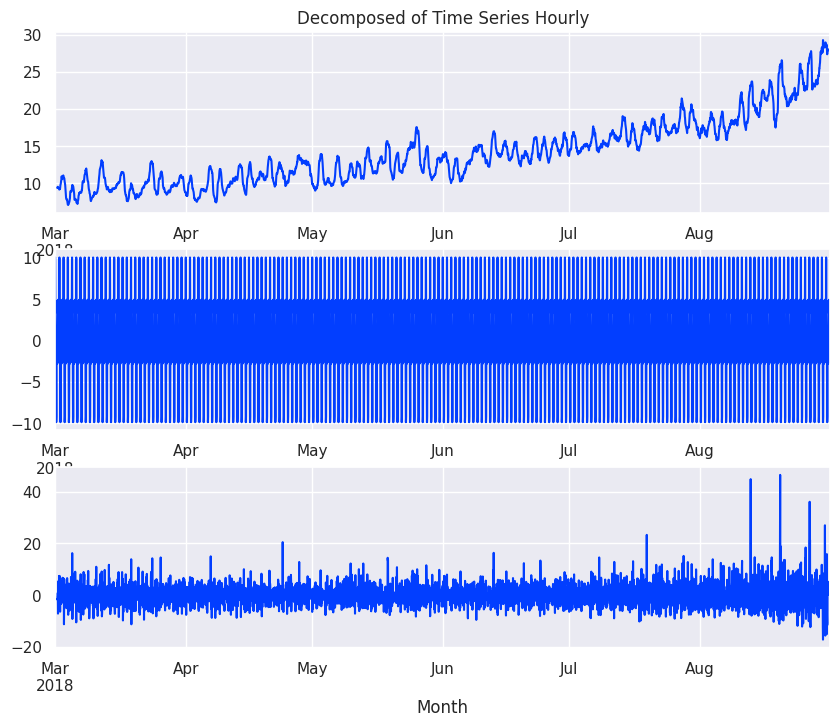

In [9]:
# membuat dekomposisi time series
decomposed = seasonal_decompose(df['num_orders'])

# visualisasi garis trend pada time series
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.title('Decomposed of Time Series Hourly')
decomposed.trend.plot(ax=plt.gca())

# visualisasi seasonal pada time series
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

# visualisasi residu pada time series
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('Month')
plt.show()

Bisa kita lihat untuk data trend memiliki kecenderungan meningkat sepanjang bulan dari bulan maret hingga agustus. Namun untuk data seasonal tidak begitu jelas, mari kita filter dataset untuk lebih mudah memahami seasonal. Kita ambil sampel data dari tanggal 1 mei 2018 hingga 15 mei 2018.

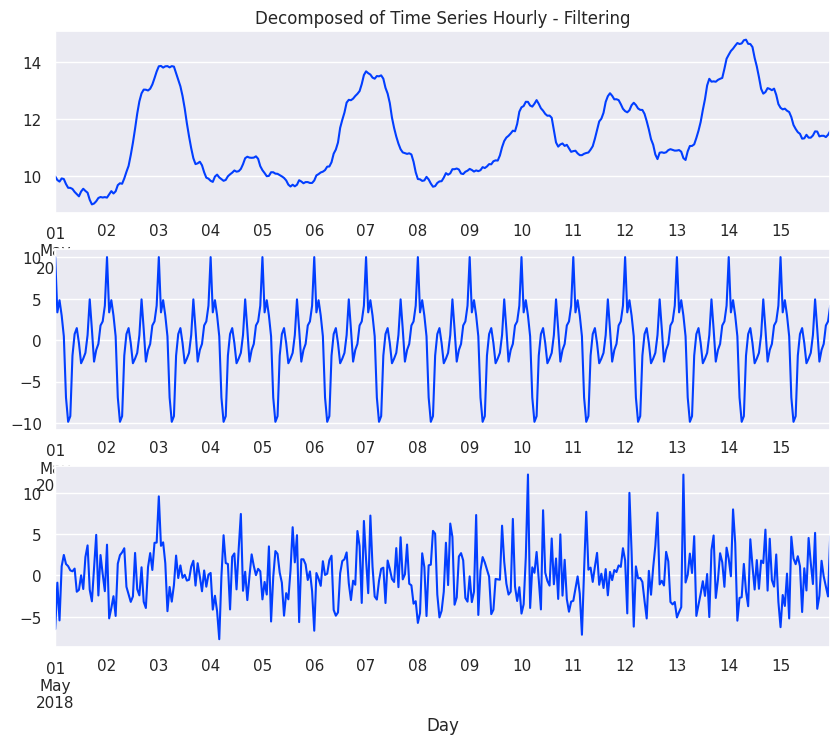

In [10]:
# memfilter decomposed time series dari tanggal 1 mei 2018 hingga 15 mei 2018
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.title('Decomposed of Time Series Hourly - Filtering')
decomposed.trend['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.subplot(313)
decomposed.resid['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.xlabel('Day')
plt.show()

Kebalikanya, kita bisa melihat data seasonal lebih jelas, namun untuk data trend tidak begitu jelas. Nampaknya kita menemukan polanya menunjukan pola seasonal harian. Mari kita perjelas lagi dengan mem-filter dataset agar menjadi harian agar bisa terlihat perubahan perjamnya, kita ambil tanggal 1 Mei 2018.

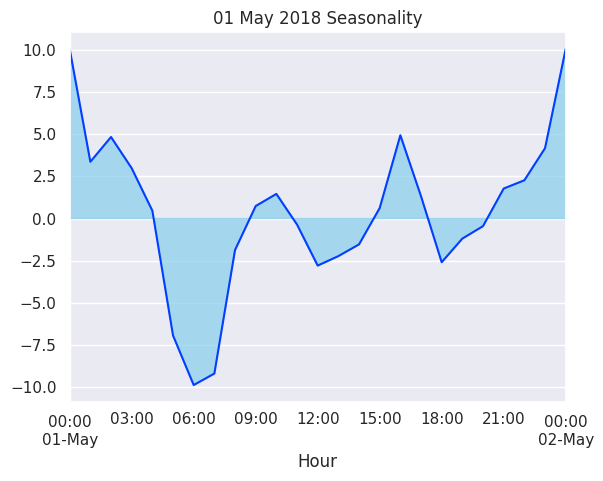

In [11]:
# memfilter seasonal pada tanggal 1 dari jam 00.00 hingga 24.00
fil_seasonal = decomposed.seasonal['2018-05-01':'2018-05-15']
fil_seasonal.head(25).plot()
plt.fill_between(fil_seasonal.index, fil_seasonal.values, color='skyblue', alpha=0.7)
plt.title('01 May 2018 Seasonality')
plt.xlabel('Hour')
plt.show()

Terlihat bahwa jam-jam sibuk terjadi pada jam 00.00 atau 24.00 dimana puncak order tertinggi dan jam longgar pada jam 06.00 dimana puncak orderan terendah. 

<AxesSubplot:xlabel='datetime'>

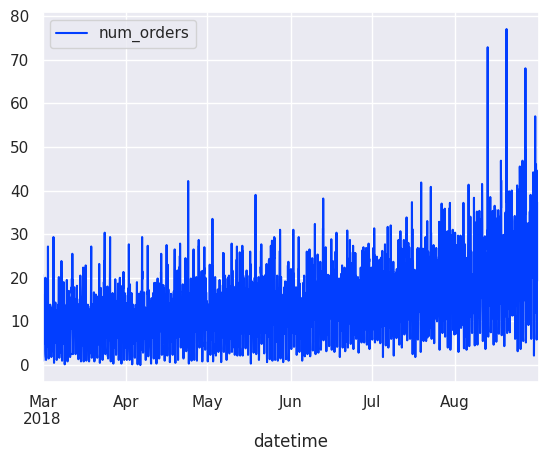

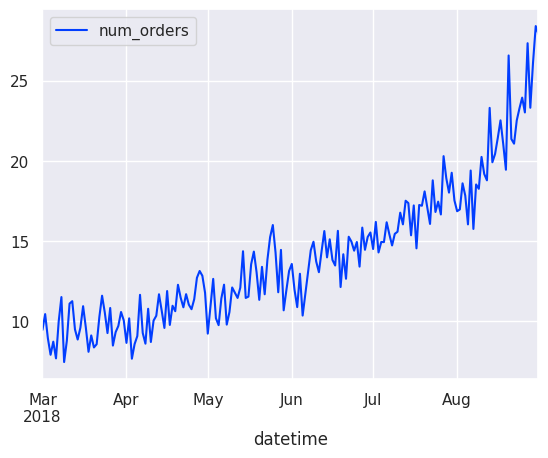

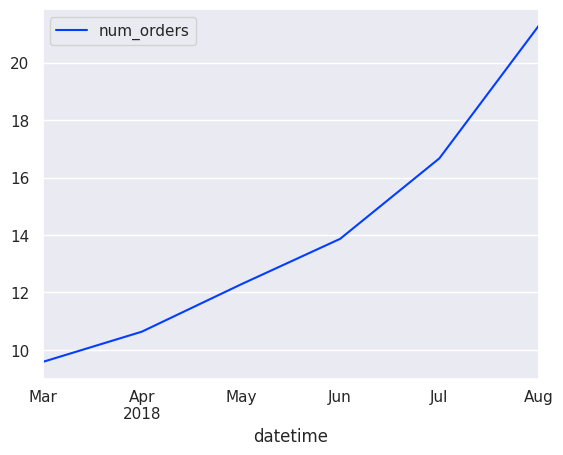

In [12]:
# Hasil grafik data resample 1H
df.plot()

# Grafik untuk data resample 1 day
df.resample('1D').mean().plot()

# Grafik untuk data resample 1 month
df.resample('1M').mean().plot()

untuk mempermudah kita akan membandingkan jumlah order per tanggal dan hari

                     num_orders  day  dayofweek
datetime                                       
2018-03-01 00:00:00   20.666667    1          3
2018-03-01 01:00:00   14.166667    1          3
2018-03-01 02:00:00   11.833333    1          3
2018-03-01 03:00:00   11.000000    1          3
2018-03-01 04:00:00    7.166667    1          3


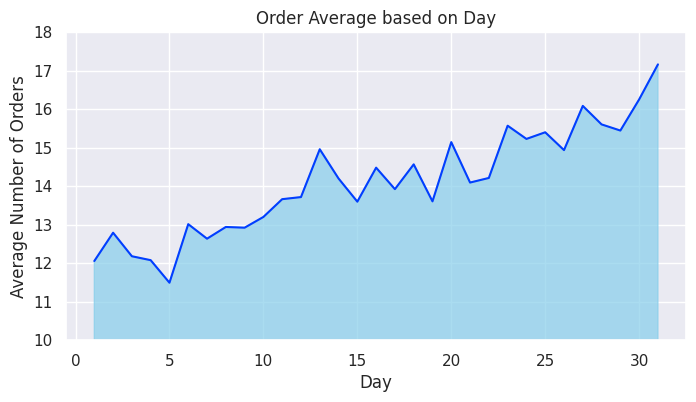

day
1     12.057870
2     12.792824
3     12.181713
4     12.079861
5     11.494213
6     13.015046
7     12.637731
8     12.942130
9     12.923611
10    13.202546
11    13.664352
12    13.718750
13    14.960648
14    14.201389
15    13.599537
16    14.482639
17    13.924769
18    14.568287
19    13.607639
20    15.145833
21    14.096065
22    14.215278
23    15.572917
24    15.229167
25    15.401620
26    14.938657
27    16.086806
28    15.606481
29    15.446759
30    16.255787
31    17.164931
Name: num_orders, dtype: float64


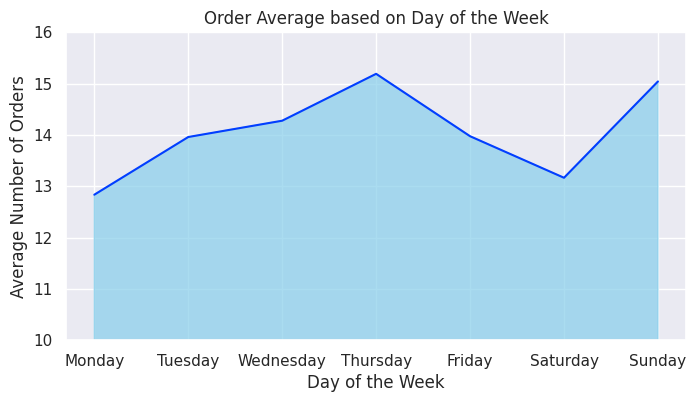

DayName
Monday       12.835203
Tuesday      13.959135
Wednesday    14.276749
Thursday     15.190072
Friday       13.974626
Saturday     13.165331
Sunday       15.041132
Name: num_orders, dtype: float64


In [13]:
# Duplikasi dataset sementara
temp = df.copy()
temp['day'] = temp.index.day                # Menambahkan kolom day
temp['dayofweek'] = temp.index.dayofweek    # Menambahkan kolom dayofweek

# Memastikan ada data yang tepat
print(temp.head())

# Melakukan plot grafik jumlah order berdasarkan tanggal
day = temp.groupby('day')['num_orders'].mean()
plt.figure(figsize=(8,4))
day.plot(kind='line')
plt.fill_between(day.index, day.values, color='skyblue', alpha=0.7)
plt.xticks(rotation=0)
plt.title('Order Average based on Day')
# Mengubah atau menghilangkan ylim sementara
plt.ylim(10,18)
plt.xlabel('Day')
plt.ylabel('Average Number of Orders')
plt.show()

# Memastikan ada data yang tepat
print(day)

# Melakukan plot grafik jumlah order berdasarkan dayofweek
day_list = {
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}
temp['DayName'] = temp['dayofweek'].map(day_list)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week = temp.groupby('DayName')['num_orders'].mean()
day_of_week = day_of_week.reindex(day_order)
plt.figure(figsize=(8,4))
day_of_week.plot(kind='line')
plt.fill_between(day_of_week.index, day_of_week.values, color='skyblue', alpha=0.7)
plt.xticks(rotation=0)
plt.title('Order Average based on Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Orders')
plt.ylim(10,16)
# Mengubah atau menghilangkan ylim sementara
plt.show()

# Memastikan ada data yang tepat
print(day_of_week)


terlihat bahwa semakin akhir bulannya semakin banyak mendapatkan order, sementara di awal bulan lebih rendah. untuk hari dengan jumlah order tertinggi adalah hari `Kamis` dan `Minggu`

**Kesimpulan:** terlihat bahwa semakin menuju bulan agustus terlihat bahwa semakin banyak orderan yang di dapatkan, untuk tanggal pada akhir bulan orderan juga mengalami peningkatan, untuk hari lebih banyak orderan pada hari `Kamis` dan `Minggu`. untuk jam terlihat pengingkatan(1 mei 2018) pada jam 21.00-02.00, dengan orderan terendah pada jam 06.00

## Pelatihan

In [14]:
df = df.resample('1H').mean()

train, test = train_test_split(df, shuffle=False, test_size=0.1)

train = train.dropna()

train.index.min(), train.index.max()
test.index.min(), test.index.max()

(Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [15]:
# Evaluasi model dengan dengan menggunakan nilai konstanta
print('harian:', test['num_orders'].median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('MAE:', mean_absolute_error(test, pred_median))

harian: 22.5
MAE: 11.798642533936652


In [16]:
# Evaluasi model dengan dengan menggunakan nilai sebelumnya dalam deret
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('MAE:', mean_absolute_error(test, pred_previous))

MAE: 7.495475113122172


pertama mari kita buat fungsi untuk fitur:

In [17]:
# membuat fitur untuk dataset
def make_features(data):
    # menduplikasi dataset
    new_df = data.copy()

    # menambahkan kolom jam, tanggal dan bulan sebagai fitur
    new_df['hour'] = new_df.index.hour
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['month'] = new_df.index.month

    # membuat kolom peak hour
    # jika puncak order tertinggi pada jam 00.00 maka 'high peak'
    # jika puncak order terendah pada jam 06.00 maka 'low peak' 
    # selainya 'normal'
    new_df['peak_hour'] = new_df['hour'].apply(lambda x: 'high peak' if x == 0 else 'low peak' if x == 6 else 'normal')

    # membuat kolom peak day of week
    # jika orderan tinggi pada hari kamis [4] atau minggu [0] maka 'high peak'  
    # jika orderan rendah pada hari senin [1] atau sabtu  [6] maka 'low peak'
    # selainya benilai 1
    new_df['peak_dow'] = new_df['dayofweek'].apply(lambda x: 'high peak' if (x == 4) | (x == 0) else 'low peak' if (x == 1) | (x == 6) else 'normal')

    # mendefinisikan akhir bulan
    # jika akhir bulan sekitar tanggal 25 keatas maka `end month`
    # selainya `regular`
    new_df['peak_day'] = new_df['day'].apply(lambda x: 'end month' if x >= 25 else 'regular')

    # mengembalikan dataset terbaru
    return new_df

In [18]:
# membuat fitur untuk dataset
new_df = make_features(df)

# menampilkan sampel dataset baru
new_df.sample(5)

,num_orders,hour,day,dayofweek,month,peak_hour,peak_dow,peak_day
datetime,,,,,,,,
2018-06-01 00:00:00,19.666667,0,1,4,6,high peak,high peak,regular
2018-05-29 18:00:00,11.166667,18,29,1,5,normal,low peak,end month
2018-04-11 12:00:00,8.833333,12,11,2,4,normal,normal,regular
2018-07-17 20:00:00,14.833333,20,17,1,7,normal,low peak,regular
2018-04-12 15:00:00,12.000000,15,12,3,4,normal,normal,regular


fitur sudah dibuatkan fungsi, sekarang mari kita membagi dataset

In [19]:
train, test = train_test_split(new_df, shuffle=False, test_size=0.1)

# membagi dataset untuk fitur dan target
x = new_df.drop('num_orders',axis=1)
y = new_df['num_orders']

# mengubah kolom kategorik menjadi numerik
x_dum = pd.get_dummies(x,drop_first=True)

# membagi dataset 10% untuk test
x_train, x_test, y_train, y_test = train_test_split(x_dum, y, test_size=0.1, shuffle=False)

membuat fungsi untuk diaplikasikan pada model:

In [20]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    # Train the model
    time_start = time.time()
    model.fit(x_train, y_train)
    time_end = time.time()
    training_time = np.round(time_end - time_start, 3)
    
    # Make predictions
    predictions = model.predict(x_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    return training_time, rmse

### Linear Regression

In [21]:
#Model linear regression
linreg = LinearRegression()

# Memanggil fungsi dan menangkap hasilnya
linreg_time, linreg_rmse = train_and_evaluate_model(linreg, x_train, y_train, x_test, y_test, model_name='Linear Regression')

# Menampilkan hasil
print(f'Linear Regression - Waktu Pelatihan: {linreg_time} detik')
print(f'Linear Regression - RMSE: {linreg_rmse}')

Linear Regression - Waktu Pelatihan: 0.006 detik
Linear Regression - RMSE: 9.843455154406492


terlihat bahwa waktu pelatihan yang dibutuhkan sangat singkat `0.039` detik dengan nilai RSME yang cukup baik `9.843`

### Random Forest

In [22]:
#model random forest
rf = RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=10, random_state=42)

rf_time, rf_rmse = train_and_evaluate_model(rf, x_train, y_train, x_test, y_test, model_name='Random Forest')

print(f'Random Forest - Waktu Pelatihan: {rf_time} detik')
print(f'Random Forest - RMSE: {rf_rmse}')

Random Forest - Waktu Pelatihan: 0.176 detik
Random Forest - RMSE: 7.850284437573134


terlihat bahwa waktu pelatihan yang dibutuhkan cukup singkat `0.201` detik dengan nilai RSME yang cukup baik `7.850`

### Decision Tree 

In [23]:
dtr = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42)

dtr_time, dtr_rmse = train_and_evaluate_model(dtr, x_train, y_train, x_test, y_test, model_name='Decision Tree')

print(f'Decision Tree - Waktu Pelatihan: {dtr_time} detik')
print(f'Decision Tree - RMSE: {dtr_rmse}')

Decision Tree - Waktu Pelatihan: 0.018 detik
Decision Tree - RMSE: 8.588346061983101


terlihat bahwa waktu pelatihan yang dibutuhkan sangat singkat `0.011` detik dengan nilai RSME yang cukup baik `8.588`

### LightGBM

In [24]:
lgbr = lgb.LGBMRegressor(n_estimators=20, max_depth=10, learning_rate=0.1, random_state=42)

lgbr_time, lgbr_rmse = train_and_evaluate_model(lgbr, x_train, y_train, x_test, y_test, model_name='LGBMRegressor')

print(f'LGBMRegressor - Waktu Pelatihan: {lgbr_time} detik')
print(f'LGBMRegressor - RMSE: {lgbr_rmse}')

LGBMRegressor - Waktu Pelatihan: 0.021 detik
LGBMRegressor - RMSE: 8.80525424046884


terlihat bahwa waktu pelatihan yang dibutuhkan cukup singkat `0.165` detik dengan nilai RSME yang cukup baik `8.805`

### XGBoost

In [25]:
xgbr = XGBRegressor(n_estimators=20, max_depth=10, learning_rate=0.1, random_state=42)

xgbr_time, xgbr_rmse = train_and_evaluate_model(xgbr, x_train, y_train, x_test, y_test, model_name='XGBRegressor')

print(f'XGBRegressor - Waktu Pelatihan: {xgbr_time} detik')
print(f'XGBRegressor - RMSE: {xgbr_rmse}')

XGBRegressor - Waktu Pelatihan: 0.511 detik
XGBRegressor - RMSE: 9.23086517232712


terlihat bahwa waktu pelatihan yang dibutuhkan cukup singkat `0.433` detik dengan nilai RSME yang cukup baik `9.230`

### Komparasi model

In [26]:
# Menggabungkan hasil model
results = [
    {'Model': 'Linear Regression', 'Training Time (s)': linreg_time, 'RMSE': linreg_rmse},
    {'Model': 'Random Forest', 'Training Time (s)': rf_time, 'RMSE': rf_rmse},
    {'Model': 'Decision Tree', 'Training Time (s)': dtr_time, 'RMSE': dtr_rmse},
    {'Model': 'LightGBM', 'Training Time (s)': lgbr_time, 'RMSE': lgbr_rmse},
    {'Model': 'XGBoost', 'Training Time (s)': xgbr_time, 'RMSE': xgbr_rmse},
]

# Mengubah hasil menjadi DataFrame
results_df = pd.DataFrame(results)

# Menampilkan tabel hasil
results_df

,Model,Training Time (s),RMSE
0,Linear Regression,0.006,9.843455
1,Random Forest,0.176,7.850284
2,Decision Tree,0.018,8.588346
3,LightGBM,0.021,8.805254
4,XGBoost,0.511,9.230865


**Kesimpulan:** waktu tersingkat pada model-model tersebut adalah pada model `decision tree` sedangkan nilai rsme terendah adalah pada model `random forest`. `linear regression` memiliki nilai rsme terbesar sehingga tidak direkomendasikan menggunakan model ini, sedangkan `xgboost` memiliki waktu prediksi paling lama diantara model lain meskipun terhitung cukup cepat. model `decision tree`, `random forest` dan `lightgbm` memiliki performa yang cukup baik untuk dipertimbangkan.

model terbaik yang bisa disarankan untuk digunakan pada tahapan ini adalah `decision tree` dengan waktu yang tidak terlalu lama dan rsme yang cukup baik

## Pengujian

### Linear Regression

In [27]:
# membuat skor RMSE
def RMSE(true,pred):
    mse = mean_squared_error(true,pred)
    return np.sqrt(mse)

RMSE_score = make_scorer(RMSE)

# melihat parameter model regresi linier
linreg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

terlihat ada beberapa parameter, kita akan memilih 2 saja untuk pengujian:

In [28]:
# mendefinisikan jumlah cross validation
cv_tmsrs = TimeSeriesSplit(n_splits=5)

# mendefinisikan parameter regresi linier
linreg_params = {
    'fit_intercept':[True,False],
    'positive':[True,False]
}

# membuat gridsearchCV untuk regresi linier menggunakan data full
time_start = time.time()
grid_linreg = GridSearchCV(linreg,param_grid=linreg_params, cv=cv_tmsrs, scoring=RMSE_score)
grid_linreg.fit(x_dum,y)
time_end = time.time()
lr_grid_time = np.round(time_end - time_start,3)

# memprediksi data train dan test menghitung skor RMSE
best_model_lr = grid_linreg.best_estimator_
linreg_pred_train = best_model_lr.predict(x_train)
linreg_RMSE_train = np.round(mean_squared_error(y_train,linreg_pred_train,squared=False),2)
linreg_pred_test = best_model_lr.predict(x_test)
linreg_RMSE_test = np.round(mean_squared_error(y_test,linreg_pred_test,squared=False),2)

print('Best Params', grid_linreg.best_params_)
print('RMSE Best-Linreg - Train:', linreg_RMSE_train)
print('RMSE Best-Linreg - Test:', linreg_RMSE_test)

Best Params {'fit_intercept': True, 'positive': True}
RMSE Best-Linreg - Train: 5.79
RMSE Best-Linreg - Test: 10.01


nilai rsme pada train terlihat memiliki nilai `5.79` dan test `10.01` sepertinya ini masih cukup baik, mari kita bandingkan dengan model-model lainnya

### Random Forest

In [29]:
# melihat parameter model random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

kita akan memasukkan beberapa parameter saja:

In [30]:
# mendefinisikan parameter random forest
rf_params = {
    'n_estimators':[50,100,200,250],
    'random_state':[42],
    'max_depth':[5,10,15],
    'min_samples_split':[3,5,10]
}

# membuat gridsearchCV untuk random forest menggunakan data full
time_start = time.time()
grid_rf = GridSearchCV(rf,param_grid=rf_params, cv=cv_tmsrs, scoring=RMSE_score)
grid_rf.fit(x_dum,y)
time_end = time.time()
rf_grid_time = np.round(time_end - time_start,3)

# memprediksi data train dan test menghitung skor RMSE
best_model_rf = grid_rf.best_estimator_
rf_pred_train = best_model_rf.predict(x_train)
rf_RMSE_train = np.round(mean_squared_error(y_train,rf_pred_train,squared=False),2)
rf_pred_test = best_model_rf.predict(x_test)
rf_RMSE_test = np.round(mean_squared_error(y_test,rf_pred_test,squared=False),2)

print('Best Params', grid_rf.best_params_)
print('RMSE Best-RF - Train:', rf_RMSE_train)
print('RMSE Best-RF - Test:', rf_RMSE_test)

Best Params {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 250, 'random_state': 42}
RMSE Best-RF - Train: 4.28
RMSE Best-RF - Test: 6.45


nilai rsme pada train terlihat memiliki nilai `4.28` dan test `6.45` ini lebih baik daripada model sebelumnya

### Decision tree

In [31]:
# melihat parameter model decision tree
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

kita akan mengambil beberapa parameters saja

In [32]:
# mendefinisikan parameter decision tree
dtr_params = {
    'random_state':[42],
    'max_depth':[5,10,15],
    'min_samples_split':[3,5,10]
}

# membuat gridsearchCV untuk random forest menggunakan data full
time_start = time.time()
grid_dtr = GridSearchCV(dtr,param_grid=dtr_params, cv=cv_tmsrs, scoring=RMSE_score)
grid_dtr.fit(x_dum,y)
time_end = time.time()
dtr_grid_time = np.round(time_end - time_start,3)

# memprediksi data train dan test menghitung skor RMSE
best_model_dtr = grid_dtr.best_estimator_
dtr_pred_train = best_model_dtr.predict(x_train)
dtr_RMSE_train = np.round(mean_squared_error(y_train,dtr_pred_train,squared=False),2)
dtr_pred_test = best_model_dtr.predict(x_test)
dtr_RMSE_test = np.round(mean_squared_error(y_test,dtr_pred_test,squared=False),2)

print('Best Params', grid_dtr.best_params_)
print('RMSE Best-DT- Train:', dtr_RMSE_train)
print('RMSE Best-DT - Test:', dtr_RMSE_test)

Best Params {'max_depth': 5, 'min_samples_split': 3, 'random_state': 42}
RMSE Best-DT- Train: 4.61
RMSE Best-DT - Test: 6.67


nilai rsme pada train terlihat memiliki nilai `4.61` dan test `6.67` ini cukup baik

### LightGBM

In [33]:
# melihat parameter model ligthGBM
lgbr.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 20,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

kita akan menggunakan beberapa parameter saja

In [34]:
# mendefinisikan parameter lgbm
param_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'verbose': -1
}

# Membuat dataset LightGBM
train_data = lgb.Dataset(data=x_train, label=y_train)

# Menggunakan KFold untuk cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = lgb.cv(
    params=param_lgb,
    train_set=train_data,
    num_boost_round=1000,
    early_stopping_rounds=10,
    folds=kf,
    metrics='rmse'
)

# Melatih model dengan jumlah iterasi optimal dari cross-validation

lgbm_model = lgb.train(
    params=param_lgb,
    train_set=train_data,
    num_boost_round=len(cv_results['rmse-mean'])
)

# memprediksi data train dan test
lgb_pred_train = lgbm_model.predict(x_train)
lgb_pred_test = lgbm_model.predict(x_test)

# menghitung skor RMSE untuk model LightGBM akhir
lgb_RMSE_opt_train = np.round(mean_squared_error(y_train, lgb_pred_train, squared=False), 2)
lgb_RMSE_opt_test = np.round(mean_squared_error(y_test, lgb_pred_test, squared=False), 2)

print('RMSE LightGBM - Train:', lgb_RMSE_opt_train)
print('RMSE LightGBM - Test:', lgb_RMSE_opt_test)

RMSE LightGBM - Train: 2.88
RMSE LightGBM - Test: 7.12


nilai rsme pada train terlihat memiliki nilai `2.88` dan test `7.12` ini cukup baik

### XGBoost

In [35]:
# melihat parameter model xgboost
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 20,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

kita hanya akan menggunakan beberapa parameter saja

In [37]:
# Mendefinisikan parameter XGBoost
xgb_params = {
    'n_estimators': [250, 500],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.2],
    'random_state': [42]
}

# Membuat RandomizedSearchCV untuk XGBoost menggunakan data full
time_start = time.time()

# Menggunakan RandomizedSearchCV alih-alih GridSearchCV
random_search_xgb = RandomizedSearchCV(xgbr, param_distributions=xgb_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
random_search_xgb.fit(x_dum, y)
time_end = time.time()
xgb_search_time = np.round(time_end - time_start, 3)

# Memprediksi data train dan test, menghitung skor RMSE
best_model_xgb = random_search_xgb.best_estimator_
xgb_pred_train = best_model_xgb.predict(x_train)
xgb_RMSE_train = np.round(mean_squared_error(y_train, xgb_pred_train, squared=False), 2)
xgb_pred_test = best_model_xgb.predict(x_test)
xgb_RMSE_test = np.round(mean_squared_error(y_test, xgb_pred_test, squared=False), 2)

print('Best Params:', random_search_xgb.best_params_)
print('RMSE Best-XGB - Train:', xgb_RMSE_train)
print('RMSE Best-XGB - Test:', xgb_RMSE_test)
print('Search Time:', xgb_search_time, 'seconds')

Best Params: {'random_state': 42, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01}
RMSE Best-XGB - Train: 3.24
RMSE Best-XGB - Test: 5.1
Search Time: 128.605 seconds


nilai rsme pada train terlihat memiliki nilai `3.24` dan test `5.1` ini cukup baik

### Komparasi Akhir

In [44]:
# membuat tabel komparasi
table_comp = pd.DataFrame(data = {
    'RMSE Original': [linreg_rmse,rf_rmse,dtr_rmse, lgbr_rmse,xgbr_rmse],
    'RMSE-Opt Train ': [linreg_RMSE_train,rf_RMSE_train, dtr_RMSE_train, lgb_RMSE_opt_train,xgb_RMSE_train],
    'RMSE-Opt Test': [linreg_RMSE_test,rf_RMSE_test, dtr_RMSE_test, lgb_RMSE_opt_test,xgb_RMSE_test],
    'Time (Seconds)': [linreg_time,rf_time,dtr_time, lgbr_time,xgbr_time]
}, index=['Linear Regression','Random Forest','Decision Tree','LightGBM','XGBoost',])

# menampilkan tabel komparasi
table_comp

,RMSE Original,RMSE-Opt Train,RMSE-Opt Test,Time (Seconds)
Linear Regression,9.843455,5.79,10.01,0.006
Random Forest,7.850284,4.28,6.45,0.176
Decision Tree,8.588346,4.61,6.67,0.018
LightGBM,8.805254,2.88,7.12,0.021
XGBoost,9.230865,3.24,5.10,0.511


**Kesimpulan:** rmse train dan test tertinggi pada model `linear regression`, sedangkan `xgboost` yang memiliki nilai rmse original tertinggi justru rmse train dan test nya tidak terlalu tinggi, malah nilai rmse testnya justru paling rendah dibandingkan model lainnya. `random forest` memiliki nilai rmse secara keseluruhan dengan range yang cukup kecil. begitu pula dengsn `decision tree` akan tetapi waktu untuk model ini 10 kali lebih kecil daripada `random forest`. `lightlgbm` memiliki nilai rmse train paling rendah akan tetapi dengan rmse test yang cukup tinggi.

rmse pada test secara keseluruhan tidak ada yang melebihi `48`

jika membutuhkan waktu yang sangat cepat disarankan menggunakan model `decision tree` akan tetapi jika ingin performa yang paling baik lebih baik menggunakan `random forest`

## Kesimpulan

1. terlihat bahwa semakin menuju bulan agustus terlihat bahwa semakin banyak orderan yang di dapatkan, untuk tanggal pada akhir bulan orderan juga mengalami peningkatan, untuk hari lebih banyak orderan pada hari `Kamis` dan `Minggu`. untuk jam terlihat pengingkatan(1 mei 2018) pada jam 21.00-02.00, dengan orderan terendah pada jam 06.00
2. waktu tersingkat pada model-model tersebut adalah pada model `decision tree` sedangkan nilai rsme terendah adalah pada model `random forest`. `linear regression` memiliki nilai rsme terbesar sehingga tidak direkomendasikan menggunakan model ini, sedangkan `xgboost` memiliki waktu prediksi paling lama diantara model lain meskipun terhitung cukup cepat. model `decision tree`, `random forest` dan `lightgbm` memiliki performa yang cukup baik untuk dipertimbangkan.
3. rmse train dan test tertinggi pada model `linear regression`, sedangkan `xgboost` yang memiliki nilai rmse original tertinggi justru rmse train dan test nya tidak terlalu tinggi, malah nilai rmse testnya justru paling rendah dibandingkan model lainnya. `random forest` memiliki nilai rmse secara keseluruhan dengan range yang cukup kecil. begitu pula dengsn `decision tree` akan tetapi waktu untuk model ini 10 kali lebih kecil daripada `random forest`. `lightlgbm` memiliki nilai rmse train paling rendah akan tetapi dengan rmse test yang cukup tinggi.


### Temuan

1. dataset berisikan 2 kolom dengan 26496 entry, tidak ada nilai hilang, akan tetapi kolom datetime memiliki tipe data yang salah sehingga harus diubah menjadi tipe data datetime lalu diubah menjadi index. tidak ada nilai hilang dan duplikasi pada dataset ini.
2. dataset memerlukan seasonal untuk pengelompokkan agar mudah dianalisa
3. rmse pada test secara keseluruhan tidak ada yang melebihi `48`

### Rekomendasi

1. model terbaik yang bisa disarankan untuk digunakan pada tahapan pelatihan adalah `decision tree` dengan waktu yang tidak terlalu lama dan rsme yang cukup baik
2. jika membutuhkan waktu yang sangat cepat disarankan menggunakan model `decision tree` akan tetapi jika ingin performa yang paling baik lebih baik menggunakan `random forest`